# Предобработка данных

In [3]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Специфические преобразования

In [5]:
#PATH ='/content/drive/My Drive/мои временные ряды/' 

In [2]:
# Загрузим набор данных

df = pd.read_csv('freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

В предыдущем уроке мы заметили отрицательную величину убытка для некоторых наблюдений. Заметим, что для всех таких полисов переменная "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [3]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [4]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [5]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [6]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


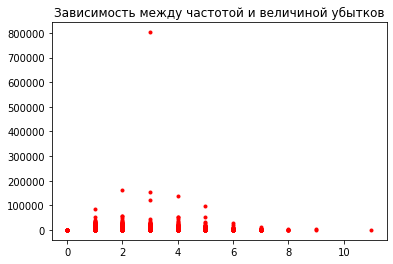

In [7]:

import seaborn as sns
plt.plot(df['ClaimsCount'],df['ClaimAmount'], '.r')
plt.title('Зависимость между частотой и величиной убытков')
plt.show()

Для моделирования среднего убытка можем рассчитать его как отношение величины убытков к их частоте.

In [8]:
df.loc[df.ClaimsCount > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']

## Общие преобразования

Класс для общих случаев

In [9]:
class InsDataFrame:


    ''' Load data method '''

    def load_pd(self, pd_dataframe):
        self._df = pd_dataframe


    ''' Columns match method '''

    def columns_match(self, match_from_to):
        self._df.rename(columns=match_from_to, inplace=True)


    ''' Person data methods '''

    # Gender
    _gender_dict = {'Male':0, 'Female':1}

    def transform_gender(self):
        self._df['Gender'] = self._df['Gender'].map(self._gender_dict)

        

    # Age
    @staticmethod
    def _age(age, age_max):
        if pd.isnull(age):
            age = None
        elif age < 18:
            age = None
        elif age > age_max:
            age = age_max
        return age
      
    def transform_age(self, age_max=70):
        self._df['driver_minage'] = self._df['driver_minage'].apply(self._age, args=(age_max,))

    # Age M/F
    @staticmethod
    def _age_gender(age_gender):
        _age = age_gender[0]
        _gender = age_gender[1]
        if _gender == 0: #Male
            _driver_minage_m = _age
            _driver_minage_f = 18
        elif _gender == 1: #Female
            _driver_minage_m = 18
            _driver_minage_f = _age
        else:
            _driver_minage_m = 18
            _driver_minage_f = 18
        return [_driver_minage_m, _driver_minage_f]
    
    def transform_age_gender(self):
        self._df['driver_minage_m'],self._df['driver_minage_f'] = zip(*self._df[['driver_minage','Gender']].apply(self._age_gender, axis=1).to_frame()[0])

    # Experience
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        elif exp > exp_max:
            exp = exp_max
        return exp

    def transform_exp(self, exp_max=52):
        self._df['driver_minexp'] = self._df['driver_minexp'].apply(self._exp, args=(exp_max,))


    ''' Other data methods '''

    def polynomizer(self, column, n=2):
        if column in list(self._df.columns):
            for i in range(2,n+1):
                self._df[column+'_'+str(i)] = self._df[column]**i

    def get_dummies(self, columns):
        self._df = pd.get_dummies(self._df, columns=columns)


    ''' General methods '''

    def info(self):
        return self._df.info()

    def head(self, columns, n=5):
        return self._df.head(n)

    def len(self):
        return len(self._df)

    def get_pd(self, columns):
        return self._df[columns]

Создаем класс-наследник, в котором переопределяем некоторые методы, специфические для конкретной ситуации, и создаем новые

- В данных стаж "LicAge" измеряется в неделях.
- Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [10]:
class InsDataFrame_Fr(InsDataFrame):

    # Experience (weeks to years)
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        else:
            exp * 7 // 365
        if exp > exp_max:
            exp = exp_max
        return exp

    # Marital status
    _MariStat_dict = {'Other':0, 'Alone':1}

    def transform_MariStat(self):
        self._df['MariStat'] = self._df['MariStat'].map(self._MariStat_dict)
    
    # Social category
    def transform_SocioCateg(self):
        self._df['SocioCateg'] = self._df['SocioCateg'].str.slice(0,4)

Подгружаем данные

In [11]:
data = InsDataFrame_Fr()

In [12]:
data.load_pd(df)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 17 columns):
Exposure       115155 non-null float64
LicAge         115155 non-null int64
RecordBeg      115155 non-null object
RecordEnd      59455 non-null object
Gender         115155 non-null object
MariStat       115155 non-null object
SocioCateg     115155 non-null object
VehUsage       115155 non-null object
DrivAge        115155 non-null int64
HasKmLimit     115155 non-null int64
BonusMalus     115155 non-null int64
ClaimAmount    115155 non-null float64
ClaimInd       115155 non-null int64
OutUseNb       115155 non-null float64
RiskArea       115155 non-null float64
ClaimsCount    115155 non-null float64
AvgClaim       10869 non-null float64
dtypes: float64(6), int64(5), object(6)
memory usage: 14.9+ MB


Преобразовываем параметры

In [14]:
# Переименовываем
data.columns_match({'DrivAge':'driver_minage','LicAge':'driver_minexp'})

In [15]:
# Преобразовываем
data.transform_age()
data.transform_exp()
data.transform_gender()
data.transform_MariStat()
data.transform_SocioCateg()

In [16]:
# Пересечение пола и возраста, их квадраты
data.transform_age_gender()
data.polynomizer('driver_minage_m')
data.polynomizer('driver_minage_f')

Для переменных, содержащих более 2 значений:
- либо упорядочиваем значения,
- либо используем фиктивные переменные (one-hot encoding).

**NB**: В H2O не рекомендуется использовать one-hot encoding. Тем не менее, используем здесь фиктивные переменные, чтобы в дальнейшем сохранить возможность сравнения результатов построенных моделей.

In [17]:
# Onehot encoding
data.get_dummies(['VehUsage','SocioCateg'])

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 30 columns):
Exposure                           115155 non-null float64
driver_minexp                      115155 non-null int64
RecordBeg                          115155 non-null object
RecordEnd                          59455 non-null object
Gender                             115155 non-null int64
MariStat                           115155 non-null int64
driver_minage                      115155 non-null int64
HasKmLimit                         115155 non-null int64
BonusMalus                         115155 non-null int64
ClaimAmount                        115155 non-null float64
ClaimInd                           115155 non-null int64
OutUseNb                           115155 non-null float64
RiskArea                           115155 non-null float64
ClaimsCount                        115155 non-null float64
AvgClaim                           10869 non-null float64
driver_minage_m       

In [19]:
col_features = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'VehUsage_Professional run',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
                'SocioCateg_CSP7'  
]

In [20]:
col_target = ['ClaimAmount', 'ClaimsCount', 'AvgClaim']

In [21]:
df_freq = data.get_pd(col_features+col_target)

In [22]:
df_ac = df_freq[df_freq['ClaimsCount'] > 0].reset_index().copy()

## Разделение набора данных на обучающую, валидационную и тестовую выборки

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# Разбиение датасета для частоты на train/val/test

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(df_freq[col_features], df_freq.ClaimsCount, test_size=0.3, random_state=1)
x_valid_c, x_test_c, y_valid_c, y_test_c = train_test_split(x_test_c, y_test_c, test_size=0.5, random_state=1)

In [25]:
# Разбиение датасета для среднего убытка на train/val/test 

x_train_ac, x_test_ac, y_train_ac, y_test_ac = train_test_split(df_ac[col_features], df_ac.AvgClaim, test_size=0.3, random_state=1)
x_valid_ac, x_test_ac, y_valid_ac, y_test_ac = train_test_split(x_test_ac, y_test_ac, test_size=0.5, random_state=1)

Ссылки на H2O

https://deeplearningrussia.wordpress.com/2019/10/12/intro-to-h2o-ai/


https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

## Установка H2O на Google Colaboratory и инициализация

In [27]:
!sudo apt-get install default-jre

[sudo] password for vavpavlov: 


In [29]:
!java -version

openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.20.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.20.04, mixed mode, sharing)


In [30]:
!pip install h2o

Defaulting to user installation because normal site-packages is not writeable


In [31]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,16 hours 34 mins
H2O_cluster_timezone:,Asia/Krasnoyarsk
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 22 days
H2O_cluster_name:,H2O_from_python_vavpavlov_jc6khe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.928 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


## Построение GLM для частоты страховых случаев

In [32]:
# Преобразование в H2O-Frame

h2o_train_c = h2o.H2OFrame(pd.concat([x_train_c, y_train_c], axis=1))
h2o_valid_c = h2o.H2OFrame(pd.concat([x_valid_c, y_valid_c], axis=1))
h2o_test_c = h2o.H2OFrame(pd.concat([x_test_c, y_test_c], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [33]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_poisson = H2OGeneralizedLinearEstimator(family = "poisson", link = "Log", nfolds=5)
glm_poisson.train(y="ClaimsCount", x = h2o_train_c.names[1:-1], training_frame = h2o_train_c, validation_frame = h2o_valid_c)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [34]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_poisson.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,poisson,log,"Elastic Net (alpha = 0.5, lambda = 9.667E-5 )",21,19,3,Key_Frame__upload_aea6bfac7284ed0b7fa8819546d94f2a.hex


In [35]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_poisson.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.3910256,0.004338928,0.39085978,0.38801068,0.38577974,0.3964968,0.39398104
1,mean_residual_deviance,1.0615549,0.021329349,1.0536928,1.0540658,1.0361779,1.0926073,1.0712306
2,mse,0.58868635,0.021144934,0.588183,0.58490556,0.56055784,0.6200152,0.5897702
3,null_deviance,17458.418,382.66766,17276.65,17109.055,17188.822,17995.498,17722.064
4,r2,0.008001878,0.0019731733,0.011159759,0.007915487,0.005843424,0.007036326,0.008054394
5,residual_deviance,17114.006,392.31204,16832.744,16774.404,16910.422,17667.46,17385.002
6,rmse,0.76716036,0.013756928,0.7669309,0.7647912,0.74870414,0.78741044,0.76796496
7,rmsle,0.35903785,0.0035807558,0.3579599,0.35716888,0.35483143,0.3639093,0.36131978


In [36]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_poisson._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-2.565659,-1.575867
1,Gender,-0.163708,-0.079349
2,MariStat,-0.114494,-0.041245
3,HasKmLimit,-0.439625,-0.137290
4,BonusMalus,0.012823,0.196838
5,OutUseNb,0.081984,0.057037
6,RiskArea,0.010119,0.022421
7,driver_minage_m,0.000209,0.003928
8,driver_minage_f,0.012369,0.198390
9,driver_minage_m_2,0.000000,0.000000


In [37]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_poisson.coef_norm()
for x in range(len(glm_poisson.cross_validation_models())):
    pmodels[x] = glm_poisson.cross_validation_models()[x].coef_norm()
coef = pd.DataFrame.from_dict(pmodels).round(5)
coef['overall'] = abs(coef['overall'])
coef.sort_values('overall',ascending=False)

,overall,0,1,2,3,4
Intercept,1.57587,-1.57278,-1.57288,-1.56837,-1.58482,-1.58189
driver_minage_f,0.19839,0.08609,0.20420,0.25112,0.12982,0.07357
BonusMalus,0.19684,0.18423,0.20081,0.20511,0.19298,0.19861
HasKmLimit,0.13729,-0.12875,-0.13612,-0.14972,-0.13596,-0.13631
driver_minage_f_2,0.11390,-0.02451,-0.12992,-0.13852,-0.03899,-0.03180
VehUsage_Professional,0.10578,0.10475,0.08663,0.10304,0.11482,0.11899
VehUsage_Private,0.09012,-0.09976,-0.08684,-0.08976,-0.09830,-0.07552
Gender,0.07935,-0.04075,-0.07491,-0.10871,-0.05780,-0.03881
VehUsage_Professional run,0.06599,0.05985,0.07137,0.06226,0.07468,0.06054
OutUseNb,0.05704,0.06333,0.05954,0.05154,0.05276,0.05781


In [38]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

c_train_pred = glm_poisson.predict(h2o_train_c).as_data_frame()
c_valid_pred = glm_poisson.predict(h2o_valid_c).as_data_frame()
c_test_pred = glm_poisson.predict(h2o_test_c).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [40]:
# Сохранение обученной модели

model_glm_poisson = h2o.save_model(model=glm_poisson, path='', force=True)

In [41]:
model_glm_poisson

'/home/vavpavlov/Education/Geekbrains/ML_in_business/Lesson_7/GLM_model_python_1605799452444_1'

## Построение GLM для среднего убытка

In [42]:
# Преобразование в H2O-Frame

h2o_train_ac = h2o.H2OFrame(pd.concat([x_train_ac, y_train_ac], axis=1))
h2o_valid_ac = h2o.H2OFrame(pd.concat([x_valid_ac, y_valid_ac], axis=1))
h2o_test_ac = h2o.H2OFrame(pd.concat([x_test_ac, y_test_ac], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [43]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_gamma = H2OGeneralizedLinearEstimator(family = "gamma", link = "Log", nfolds=5)
glm_gamma.train(y="AvgClaim", x = h2o_train_ac.names[1:-1], training_frame = h2o_train_ac, validation_frame = h2o_valid_ac)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [44]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_gamma.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gamma,log,"Elastic Net (alpha = 0.5, lambda = 2.602E-4 )",21,19,3,Key_Frame__upload_899e9289a066f25fc9324fa74474b3c.hex


In [45]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_gamma.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1192.1255,90.14436,1215.0825,1103.0563,1336.2119,1142.1202,1164.1565
1,mean_residual_deviance,2.1000102,0.17653555,2.111272,1.8979902,2.3818865,2.0620294,2.046873
2,mse,1.6246823E7,2.2577698E7,5919687.5,4799847.0,5.6531276E7,5097799.0,8885507.0
3,null_deviance,3180.871,177.56032,3210.0464,2916.3445,3402.6528,3132.8562,3242.4556
4,r2,-0.003552388,0.009638258,0.0018303794,-0.0081158895,-0.0010728154,-0.017655618,0.0072520054
5,residual_deviance,3188.6897,168.05495,3200.6885,2941.8848,3415.625,3206.4558,3178.794
6,rmse,3476.2625,2281.015,2433.0408,2190.8552,7518.7285,2257.8306,2980.8567
7,rmsle,1.7659888,0.03792315,1.7834941,1.7196133,1.730927,1.794598,1.8013119


In [46]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_gamma._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,7.310145,7.017288
1,Gender,-0.314623,-0.152506
2,MariStat,0.299338,0.110533
3,HasKmLimit,-0.066859,-0.016827
4,BonusMalus,-0.002345,-0.039579
5,OutUseNb,-0.021085,-0.015749
6,RiskArea,0.030396,0.067861
7,driver_minage_m,-0.021733,-0.397791
8,driver_minage_f,0.012161,0.187589
9,driver_minage_m_2,0.000179,0.268589


In [47]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_gamma.coef_norm()
for x in range(len(glm_gamma.cross_validation_models())):
    pmodels[x] = glm_gamma.cross_validation_models()[x].coef_norm()
coef_ac = pd.DataFrame.from_dict(pmodels).round(5)
coef_ac['overall'] = abs(coef['overall'])
coef_ac.sort_values('overall',ascending=False)

,overall,0,1,2,3,4
Intercept,1.57587,7.01577,7.02699,6.98162,7.02726,7.02641
driver_minage_f,0.19839,0.22621,0.32355,0.00000,0.15176,0.19353
BonusMalus,0.19684,-0.02520,-0.04086,-0.03656,-0.04664,-0.04134
HasKmLimit,0.13729,-0.02540,-0.01681,-0.00923,-0.01779,-0.01103
driver_minage_f_2,0.11390,-0.21096,-0.27289,-0.04329,-0.16013,-0.19888
VehUsage_Professional,0.10578,-0.01198,-0.02204,-0.00412,0.00000,-0.01118
VehUsage_Private,0.09012,0.00000,0.00000,0.00000,-0.01007,0.00000
Gender,0.07935,-0.12857,-0.17292,-0.22137,-0.17077,-0.05644
VehUsage_Professional run,0.06599,-0.04803,-0.04324,-0.02600,-0.05273,-0.05642
OutUseNb,0.05704,-0.01464,-0.03258,0.00197,-0.03350,0.00000


In [48]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

ac_train_pred = glm_gamma.predict(h2o_train_ac).as_data_frame()
ac_valid_pred = glm_gamma.predict(h2o_valid_ac).as_data_frame()
ac_test_pred = glm_gamma.predict(h2o_test_ac).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [50]:
# Сохранение обученной модели

model_glm_gamma = h2o.save_model(model=glm_gamma, path='', force=True)

In [51]:
model_glm_gamma

'/home/vavpavlov/Education/Geekbrains/ML_in_business/Lesson_7/GLM_model_python_1605799452444_2'

## Использование GLM моделей

In [52]:
h2o_df = h2o.H2OFrame(df_freq[col_features])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [53]:
df['CountPredicted'] = glm_poisson.predict(h2o_df).as_data_frame()
df['AvgClaimPredicted'] = glm_gamma.predict(h2o_df).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [54]:
df['BurningCost'] = df.CountPredicted * df.AvgClaimPredicted
df[['CountPredicted', 'AvgClaimPredicted', 'BurningCost']].head()

,CountPredicted,AvgClaimPredicted,BurningCost
0,0.268689,1087.936414,292.316704
1,0.268689,1087.936414,292.316704
2,0.240122,1146.063987,275.195142
3,0.200097,1127.364931,225.582287
4,0.168869,1106.883916,186.918109


# * Домашнее задание: GLM для прогнозирования наступления страхового случая

In [56]:
# Разбиение датасета на train/val/test

df_ind = data.get_pd(col_features+['ClaimInd'])
Target = 'ClaimInd'


x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(df_ind[col_features], df_ind.ClaimInd, test_size=0.3, random_state=1)
x_valid_ind, x_test_ind, y_valid_ind, y_test_ind = train_test_split(x_test_ind, y_test_ind, test_size=0.5, random_state=1)

In [57]:
y_train_ind.head()

54963     1
66206     1
85792     0
42484     0
113082    0
Name: ClaimInd, dtype: int64

In [58]:
x_train_ind.head()

,driver_minexp,Gender,MariStat,HasKmLimit,BonusMalus,OutUseNb,RiskArea,driver_minage_m,driver_minage_f,driver_minage_m_2,...,VehUsage_Private+trip to office,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7
54963,52,1,0,0,50,0.0,10.0,18,55,324,...,1,0,0,0,0,0,0,1,0,0
66206,52,0,0,0,50,0.0,2.0,70,18,4900,...,0,0,0,0,0,0,0,0,1,0
85792,52,1,1,0,90,1.0,10.0,18,61,324,...,1,0,0,0,0,0,0,1,0,0
42484,52,1,0,0,80,0.0,10.0,18,26,324,...,1,0,0,0,0,0,0,1,0,0
113082,52,0,0,0,50,1.0,10.0,70,18,4900,...,0,0,0,0,0,0,0,0,1,0


In [59]:
x_test_ind['driver_minexp'].unique()

array([52, 28, 39, 27, 25, 48, 30, 51, 40, 26, 38, 50, 46, 31, 49, 43, 36,
       37, 42, 41, 24, 33, 29, 45, 44, 47, 34, 35, 32])

In [60]:
# Преобразование в H2O-Frame

# Преобразование в H2O-Frame

h2o_train_ind = h2o.H2OFrame(pd.concat([x_train_ind, y_train_ind], axis=1))
h2o_valid_ind = h2o.H2OFrame(pd.concat([x_valid_ind, y_valid_ind], axis=1))
h2o_test_ind = h2o.H2OFrame(pd.concat([x_test_ind, y_test_ind], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [61]:
# Преобразуем целевую переменную ClaimInd в категориальную при помощи метода asfactor во всех наборах данных
print(h2o_train_ind[Target].head())
h2o_train_ind[Target] = h2o_train_ind[Target].asfactor()
print(h2o_train_ind[Target].head())
print(h2o_train_ind[Target].unique())

ClaimInd
1
1
0
0
0
0
0
0
0
0


ClaimInd
1
1
0
0
0
0
0
0
0
0


C1
0
1


In [62]:
h2o_test_ind[Target] = h2o_test_ind[Target].asfactor()
h2o_valid_ind[Target] = h2o_valid_ind[Target].asfactor()

In [63]:
list_col=np.array(h2o_test_ind.columns_by_type(coltype="categorical")).astype(int).tolist()
h2o_test_ind[list_col]

ClaimInd
0
0
0
0
0
0
0
0
0
0


In [64]:
h2o_train_ind.shape, h2o_test_ind.shape, h2o_valid_ind.shape

((80608, 23), (17274, 23), (17273, 23))

/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning

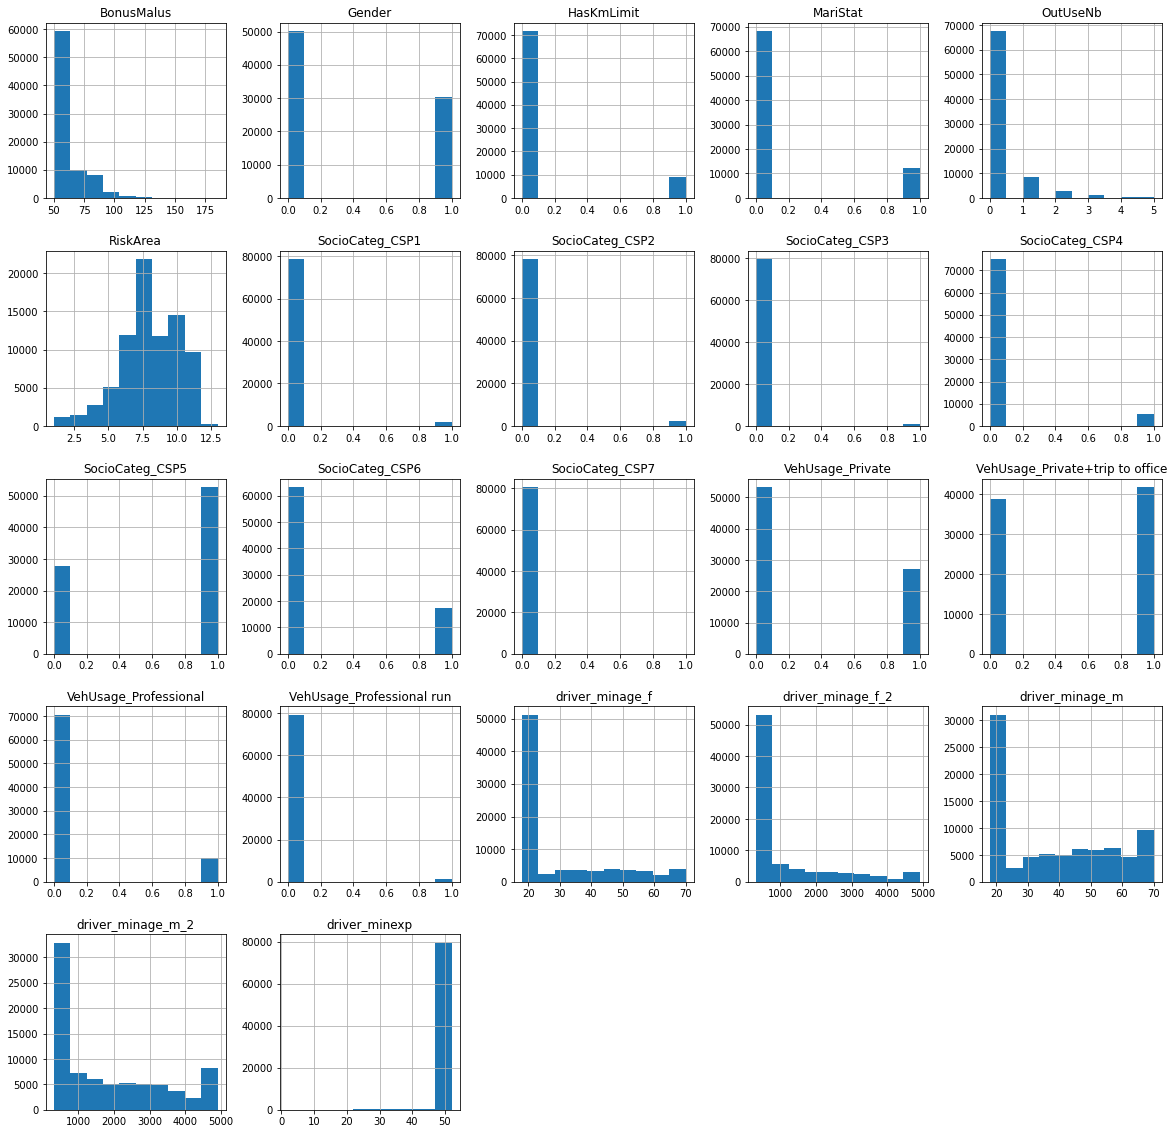

In [65]:
h2o_train_ind[:-1].as_data_frame().hist(figsize=(20,20))
plt.show()

In [66]:
h2o_train_ind.names

['driver_minexp',
 'Gender',
 'MariStat',
 'HasKmLimit',
 'BonusMalus',
 'OutUseNb',
 'RiskArea',
 'driver_minage_m',
 'driver_minage_f',
 'driver_minage_m_2',
 'driver_minage_f_2',
 'VehUsage_Private',
 'VehUsage_Private+trip to office',
 'VehUsage_Professional',
 'VehUsage_Professional run',
 'SocioCateg_CSP1',
 'SocioCateg_CSP2',
 'SocioCateg_CSP3',
 'SocioCateg_CSP4',
 'SocioCateg_CSP5',
 'SocioCateg_CSP6',
 'SocioCateg_CSP7',
 'ClaimInd']

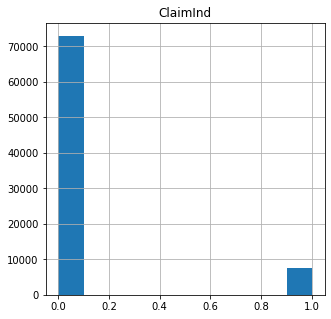

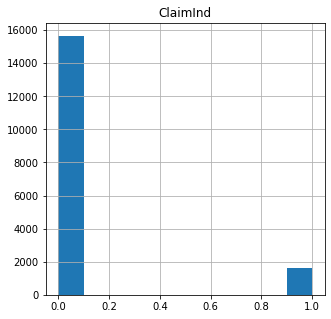

In [67]:
h2o_train_ind[Target].as_data_frame().hist(figsize=(5,5))
plt.show()
h2o_test_ind[Target].as_data_frame().hist(figsize=(5,5))
plt.show()

In [68]:
df_ind = data.get_pd(col_features+['ClaimInd'])

x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(df_ind[col_features], df_ind.ClaimInd, test_size=0.3, random_state=1)
x_valid_ind, x_test_ind, y_valid_ind, y_test_ind = train_test_split(x_test_ind, y_test_ind, test_size=0.5, random_state=1)

h2o_train_ind = h2o.H2OFrame(pd.concat([x_train_ind, y_train_ind], axis=1))
h2o_valid_ind = h2o.H2OFrame(pd.concat([x_valid_ind, y_valid_ind], axis=1))
h2o_test_ind = h2o.H2OFrame(pd.concat([x_test_ind, y_test_ind], axis=1))

h2o_train_ind['ClaimInd'] = h2o_train_ind['ClaimInd'].asfactor()
h2o_valid_ind['ClaimInd'] = h2o_valid_ind['ClaimInd'].asfactor()
h2o_test_ind['ClaimInd'] = h2o_test_ind['ClaimInd'].asfactor()



Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [69]:
# Инициализируем и обучим GLM модель c кросс-валидацией
glm_binomial = H2OGeneralizedLinearEstimator(family = "binomial", link = "logit", nfolds=5, balance_classes=True)
glm_binomial.train(y = "ClaimInd", x = h2o_train_ind.names[1:-2], training_frame = h2o_train_ind, validation_frame = h2o_valid_ind)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [71]:
glm_binomial.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 2.368E-5 )",20,20,3,py_12_sid_b9eb


In [72]:
glm_binomial.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.4675402,0.121271595,0.29869723,0.4371518,0.6165278,0.4381815,0.5471427
1,auc,0.563332,0.009054313,0.5488927,0.5703069,0.5646495,0.56139815,0.571413
2,aucpr,0.11389955,0.005453769,0.10784654,0.121078536,0.11625854,0.10906188,0.11525225
3,err,0.5324598,0.121271595,0.70130277,0.5628482,0.3834722,0.56181854,0.45285732
4,err_count,8584.0,1944.6154,11197.0,9193.0,6167.0,9120.0,7243.0
5,f0point5,0.1328656,0.008267254,0.122014485,0.13722378,0.14185491,0.1264829,0.13675186
6,f1,0.1883056,0.0073103495,0.17928608,0.19648632,0.19269538,0.18206277,0.19099744
7,f2,0.3250831,0.0178881,0.33788264,0.34584615,0.3003346,0.3247792,0.31657287
8,lift_top_group,1.3477367,0.30491936,1.7471212,1.2425635,1.2989362,0.93448085,1.5155817
9,logloss,0.31122002,0.0050693955,0.30811423,0.318478,0.31323156,0.30518612,0.31109017


In [74]:
pmodels = {}
pmodels['overall'] = glm_binomial.coef_norm()
for x in range(len(glm_binomial.cross_validation_models())):
    pmodels[x] = glm_binomial.cross_validation_models()[x].coef_norm()
coef = pd.DataFrame.from_dict(pmodels).round(5)
coef['overall'] = abs(coef['overall'])
coef.sort_values('overall', ascending=False)

,overall,0,1,2,3,4
Intercept,2.27964,-2.27637,-2.28923,-2.28276,-2.27179,-2.27933
HasKmLimit,0.11551,-0.11043,-0.11479,-0.11880,-0.11380,-0.11963
BonusMalus,0.10427,0.10682,0.09489,0.10125,0.10926,0.10200
VehUsage_Professional,0.07470,0.08068,0.06725,0.07846,0.09178,0.06744
driver_minage_m,0.07014,-0.05935,-0.06407,-0.03765,-0.27352,-0.24835
VehUsage_Private,0.06792,-0.07126,-0.06175,-0.07598,-0.06428,-0.05474
OutUseNb,0.04272,0.05653,0.04868,0.03706,0.02705,0.04421
VehUsage_Professional run,0.03964,0.04394,0.03685,0.03705,0.04191,0.04345
Gender,0.03108,-0.01040,-0.04117,-0.02473,-0.06788,-0.07000
SocioCateg_CSP2,0.02430,-0.02796,-0.02463,-0.01475,-0.02878,-0.00810


In [75]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации
glm_binomial._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-2.475904e+00,-2.279636
1,Gender,-6.412230e-02,-0.031080
2,MariStat,-6.469010e-02,-0.023304
3,HasKmLimit,-3.698690e-01,-0.115506
4,BonusMalus,6.792700e-03,0.104270
5,OutUseNb,6.140907e-02,0.042723
6,RiskArea,9.237981e-03,0.020468
7,driver_minage_m,-3.724896e-03,-0.070142
8,driver_minage_f,-1.167387e-03,-0.018724
9,driver_minage_m_2,-6.162300e-06,-0.009621


In [76]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок
y_pred=glm_binomial.predict(h2o_test_ind).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


In [77]:
y_pred.head()

,predict,p0,p1
0,0,0.908986,0.091014
1,1,0.879293,0.120707
2,1,0.886150,0.113850
3,0,0.922013,0.077987
4,1,0.903523,0.096477


In [78]:
y_pred.shape

(17274, 3)

In [79]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [80]:
confusion_matrix(y_test_ind, y_pred['predict'])

array([[9175, 6474],
       [ 801,  824]])

In [81]:
glm_binomial.confusion_matrix(train=True, valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09479152927183596: 


,,0,1,Error,Rate
0,0,42718.0,30255.0,0.4146,(30255.0/72973.0)
1,1,3731.0,3904.0,0.4887,(3731.0/7635.0)
2,Total,46449.0,34159.0,0.4216,(33986.0/80608.0)



Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09480046143327027: 


,,0,1,Error,Rate
0,0,9224.0,6440.0,0.4111,(6440.0/15664.0)
1,1,784.0,825.0,0.4873,(784.0/1609.0)
2,Total,10008.0,7265.0,0.4182,(7224.0/17273.0)


{'train': , 'valid': }

In [82]:
glm_binomial.accuracy()

[[0.2855621219839621, 0.9052699483922191]]